In [1]:
version='kc_gnn_16'


'''
KNN based (n=200) graph distance +numeric edge feat , train end date change + bigger training data
'''

'\nKNN based (n=200) graph distance +numeric edge feat , train end date change + bigger training data\n'

In [2]:

import collections
import copy
import csv
import math
import numbers
import random
import threading
import time
import types
import warnings
from functools import partial, update_wrapper

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, NeighborLoader, NeighborSampler
from torch_geometric.nn import SAGEConv, TransformerConv,NNConv
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
import torch_geometric
torch_geometric.__version__
torch.__version__
print(torch.version.cuda)
import sys
# sys.path
# sys.path.append('zestimate-neural-net')
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import DataFrame, SparkSession
# from pyspark.sql import functions as F
# from pyspark.sql import types as T
# from pyspark.sql.window import Window

# from aip_spark_sdk import AwsHelper
import pandas as pd
import numpy as np
import collections
import copy
import csv
import math
# import numbers
# import random
# import threading
# import time
# import types
import warnings
from functools import partial, update_wrapper

import matplotlib.pyplot as plt
# import networkx as nx
import numpy as np
import pandas as pd
# import torch.nn as nn
# import torch.nn.functional as F
# from sklearn.metrics import mean_absolute_error, median_absolute_error
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.metrics import r2_score
from sklearn.neighbors import BallTree
pd.set_option('display.max_columns', None)
print(torch.cuda.is_available())

11.6
True


In [3]:
def get_feature_dict():
    num_features = [
        "latitude",
        "longitude",
        "year_built",
        "year_reno",
        "grade",
        "fbsmt_grade",
        "condition",
        "stories",
        "beds",
        "bath_full",
        "bath_3qtr",
        "bath_half",
    ]
    num_log_features = [
        "land_val",
        "imp_val",
        "sqft_lot",
        "sqft",
        "sqft_1",
        "sqft_fbsmt",
        "garb_sqft",
        "gara_sqft",
    ]
    cat_features = [
        # "area",
        "city",
       "submarket",
        "zoning",
        # "present_use",

        # "wfnt",
        # "golf",
        # "greenbelt",
        # "noise_traffic",
        # "view_rainier",
        # "view_olympics",
        # "view_cascades",
        # "view_territorial",
        # "view_skyline",
        # "view_sound",
        # "view_lakewash",
        # "view_lakesamm",
        # "view_otherwater",
        # "view_other",
        
        # "sale_date_yyyymm",
        # "sale_decade",
        # "sale_year",
        # "sale_week",
    ]
    ord_features = [
        # "stories",
        # "beds",
        # "bath_full",
        # "bath_3qtr",
        # "bath_half",
    ]
    time_features = ["sale_date",]

    feature_dict = {
        "nums": num_features,
        "num_logs": num_log_features,
        "cats": cat_features,
        "ords": ord_features,
        "time": time_features,
    }

    return feature_dict


feature_dict = get_feature_dict()

id_cols = ["sale_id", "pinx", "submarket"]
response_col = "sale_price"
feature_cols = set(
    feature_dict["nums"] +
    feature_dict["num_logs"] +
    feature_dict["cats"] +
    feature_dict["ords"] +
    feature_dict["time"]
)

In [4]:
df=pd.read_csv('kingcountysales.csv')
df["sale_date"]=pd.to_datetime(df["sale_date"])
max_train_date = "2021-01-01"
min_train_date = "2016-01-01"
sample_beg_date= "2015-01-01"
df_1= df[df["sale_date"] >= min_train_date].copy()


In [5]:
class ResponseTransformer:
    """Response transformer."""
    def __init__(self):
        self.median = None

    def fit(self, y):
        y_trans = np.log1p(y)
        self.median = np.median(y_trans)
        return self

    def transform(self, y):
        y = np.log1p(y) - self.median
        return y

    def fit_transform(self, y):
        return self.fit(y).transform(y)

    def inverse_transform(self, y):
        y = np.expm1(y + self.median)
        return y

In [6]:
def prepare_missing(df):
    df = (
        df
        .assign(imp_val=lambda x: x['imp_val'].replace(0, np.nan))
        .assign(land_val=lambda x: x['land_val'].replace(0, np.nan))
        .assign(sqft=lambda x: x['sqft'].replace(0, np.nan))
        .assign(beds=lambda x: x['beds'].replace(54, np.nan))
    )
    return df
def clean_sqft(df):
    sqft_1 = df.query('sqft < sqft_1')['sqft_1']
    sqft_fbsmt = df.query('sqft < sqft_1')['sqft_fbsmt']
    df.loc[df['sqft'] < df['sqft_1'], 'sqft'] = sqft_1 + sqft_fbsmt
    return df

def clean_year_built(df):
    df['build_type'] = 'Standard'
    df.loc[(df['year_built'] - 1) == pd.to_datetime(df['sale_date']).dt.year, 'build_type'] = 'New Construction'
    df.loc[(df['year_built'] - 1) > pd.to_datetime(df['sale_date']).dt.year, 'build_type'] = 'Lot Sale'
    return df

def prepare_outliers(df):
    df = (
        df
        .pipe(clean_sqft)
        .pipe(clean_year_built)
    )
    return df

def preprocessor(df_1, feature_c):
    df_out=df_1.copy()
    # feature_cols=feature_c.copy()
    
    '''
    categorical features: replace each category with its price statistics from prior years  
    '''
    df_sample=  df[(df["sale_date"] < min_train_date) & (df["sale_date"] >= sample_beg_date)].copy()
    trans_1=ResponseTransformer()
    df_sample[response_col]=trans_1.fit_transform(df_sample[response_col].values)
    # df_sample[response_col]= np.log1p(df_sample[response_col].values) - df_sample[response_col].median()
    for cat_col in feature_dict['cats']:
        cat_stats= df_sample[[cat_col,response_col]].groupby(cat_col).describe().add_prefix(f'{cat_col}_')[f'{cat_col}_sale_price'].reset_index()
        df_out=df_out.merge(cat_stats, how='left', on=cat_col)
        print(cat_col)
        print(df_out.shape)
        print(df_out['sale_date'].isna().sum())
        df_out.drop(columns=cat_col, inplace=True)
        feature_cols.update(list(cat_stats.columns))
        feature_cols.remove(cat_col)
        
    '''
    temporal adjusting 
    '''
    print(df_out['sale_date'].isna().sum())
    date_time = df_out['sale_date']

    timestamp_s = date_time.dt.week
    # df_1['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    # df_1['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df_out['year_sin'] = np.sin(timestamp_s * (2 * np.pi / 52))
    df_out['year_cos'] = np.cos(timestamp_s * (2 * np.pi / 52))
    # df_out.drop(columns='sale_date', inplace=True)
    df_out['trans_year']=date_time.dt.year
    feature_cols.update(['trans_year','year_sin','year_cos'])
    feature_cols.remove('sale_date')
    
    '''
    taking log
    '''
    
    df_out[feature_dict['num_logs']]=np.log1p(df_out[feature_dict['num_logs']])
    '''
    filling missing values
    '''
    
    df_out.fillna(df_out.median(), inplace=True)
    # print(df_out.isna().sum())
    # df_out.dropna(inplace=True)
    return df_out, feature_cols
        

In [7]:
feature_cols = set(
    feature_dict["nums"] +
    feature_dict["num_logs"] +
    feature_dict["cats"] +
    feature_dict["ords"] +
    feature_dict["time"]
)
old_feat_col=feature_cols.copy()
df_1=prepare_missing(df_1)
df_1=prepare_outliers(df_1)
df_out,feature_cols_2=preprocessor(df_1, feature_cols)
df_out["sale_year"] = df_out["sale_date"].dt.year
df_out["sale_month"] = df_out["sale_date"].dt.month
df_out["sale_week"] = df_out["sale_date"].dt.isocalendar().week
df_out["sale_day"] = df_out["sale_date"].dt.day

city
(161512, 56)
0
submarket
(161512, 63)
0
zoning
(161512, 70)
0
0


/tmp/ipykernel_675/1722977719.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  timestamp_s = date_time.dt.week
/tmp/ipykernel_675/1722977719.py:76: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_out.fillna(df_out.median(), inplace=True)
/tmp/ipykernel_675/1722977719.py:76: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_out.fillna(df_out.median(), inplace=True)


In [8]:
df_out['beds'].max()

21.0

In [9]:
df_train = df_out[(df_out["sale_date"] < max_train_date) & (df_out["sale_date"] >= min_train_date)].copy()
df_train = df_train.reset_index(drop=True)
df_test = df_out[df_out["sale_date"] >= max_train_date].copy()
df_test = df_test.reset_index(drop=True)



response_transformer = ResponseTransformer()




X_train=df_train[feature_cols].copy()
y_train=response_transformer.fit_transform(df_train[response_col])

X_test=df_test[feature_cols].copy()
y_test=df_test[response_col].copy()



from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train[list(X_train.columns)]=scaler.fit_transform(X_train)
X_test[list(X_test.columns)]=scaler.transform(X_test)

/tmp/ipykernel_675/2730997172.py:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train=df_train[feature_cols].copy()
/tmp/ipykernel_675/2730997172.py:16: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test=df_test[feature_cols].copy()


In [10]:
def mean_percentage_error(true, pred, epsilon=1e-6):
    """Mean Percentage Error (MPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.mean(pe)


def median_absolute_percentage_error(true, pred, epsilon=1e-6):
    """Median Absolute Percentage Error (MdAPE)."""
    ape = np.abs(pred - true) / (true + epsilon)
    return np.median(ape)


def median_percentage_error(true, pred, epsilon=1e-6):
    """Median Percentage Error (MdPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.median(pe)


def frac_within_ci(true, pred_low, pred_high):
    """Fraction within Confidence Interval."""
    wci = (true >= pred_low) & (true <= pred_high)
    return np.mean(wci)


def mean_ci_width(true, pred_low, pred_high, epsilon=1e-6):
    """Mean Confidence Interval Width."""
    ciw = (pred_high - pred_low) / (true + epsilon)
    return np.mean(ciw)


def median_ci_width(true, pred_low, pred_high, epsilon=1e-6):
    """Median Confidence Interval Width."""
    ciw = (pred_high - pred_low) / (true + epsilon)
    return np.median(ciw)


def evaluate_preds(y_test, y_pred, y_pred_low=None, y_pred_high=None):
    output = {}
    output["Count"] = len(y_test)
    output["R2"] = r2_score(y_test, y_pred)
    output["MAE"] = mean_absolute_error(y_test, y_pred)
    output["MdAE"] = median_absolute_error(y_test, y_pred)
    output["MPE"] = mean_percentage_error(y_test, y_pred)
    output["MdPE"] = median_percentage_error(y_test, y_pred)
    output["MAPE"] = mean_absolute_percentage_error(y_test, y_pred)
    output["MdAPE"] = median_absolute_percentage_error(y_test, y_pred)
    if y_pred_low is not None and y_pred_high is not None:
        output["Pct. Within CI"] = frac_within_ci(y_test, y_pred_low, y_pred_high)
        output["Mean CI Width"] = mean_ci_width(y_test, y_pred_low, y_pred_high)
        output["Med. CI Width"] = median_ci_width(y_test, y_pred_low, y_pred_high)
    return output

In [11]:
'''
mostly referencing Reid's public notebook on kaggle for typical preprocessing steps 
https://www.kaggle.com/code/reidjohnson/house-price-eda-and-modeling-with-python

'''

"\nmostly referencing Reid's public notebook on kaggle for typical preprocessing steps \nhttps://www.kaggle.com/code/reidjohnson/house-price-eda-and-modeling-with-python\n\n"

In [12]:
X_train.describe().index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [13]:
# datetime=pd.concat([df_train, df_test])['sale_date']
# min_date= datetime.min()
# t=datetime-min_date
# t=t.dt.days
    
# idx=torch.arange(len(df_train)+len(df_test))    
    
# time_edge= edge_index.clone()

# '''
# fixing the time leakage: basically removing all links that go from future to past
# '''

# t_dic=dict(zip(idx.numpy(), t.values))
# a=time_edge[0].apply_(t_dic.get)
# b=time_edge[1].apply_(t_dic.get)
# c=b-a
# new_edge=torch.cat((edge_index,torch.unsqueeze(c,0)),0)
# new_edge=new_edge[:,new_edge[2]>0]
# # new_edge=new_edge[:2]

In [14]:
class TorchStandardScaler:
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

In [15]:
from typing import Tuple

import torch

from torch_geometric.data import Data
from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import scatter
import torch_geometric.transforms as T

# assert X_train.isin([np.inf, -np.inf]).any().any() == False
# assert X_test.isin([np.inf, -np.inf]).any().any() == False



data_x = torch.Tensor(pd.concat([X_train, X_test]).values)
data_y = torch.Tensor(pd.concat([y_train, y_test]).values).reshape(-1, 1)
train_idx = torch.arange(len(X_train))
idx=torch.arange(len(X_train)+len(X_test))


'''
getting the relative days since begining for each node. 
'''

datetime=pd.concat([df_train, df_test]).reset_index()['sale_date']
min_date= datetime.min()
t=datetime-min_date
t=t.dt.days
    

data = Data(x=data_x, y=data_y)
data.train_mask = torch.tensor(np.isin(np.arange(len(data_x)), train_idx), dtype=torch.bool)


'''
get coordinates and put as the data.pos, pyg uses this for graph creation
'''

lat_long=pd.concat([df_train, df_test]).reset_index(drop=True)[['latitude', 'longitude']]

latitude=lat_long['latitude'].values
longitude=lat_long['longitude'].values
latitude = latitude * (math.pi / 180.)
longitude = longitude * (math.pi / 180.)

R = 6371  # approximate Earth radius in km
x = R * np.cos(latitude) * np.cos(longitude)
y = R * np.cos(latitude) * np.sin(longitude)
z = R * np.sin(latitude)
data.pos= torch.Tensor(np.stack((x, y,z), axis=1))


edge_transform= T.KNNGraph(k=100,force_undirected=False)
data= edge_transform(data)



# radius_transform=T.RadiusGraph(max_num_neighbors=200,r=0.5)
# data=radius_transform(data)

'''
removing leaky radius
'''



idx=torch.arange(len(df_train)+len(df_test))    
    
time_edge= data.edge_index.clone()
print(time_edge.shape)

'''
fixing the time leakage: basically removing all links that go from future to past
'''

t_dic=dict(zip(idx.numpy(), t.values))
a=time_edge[0].apply_(t_dic.get)
b=time_edge[1].apply_(t_dic.get)
c=b-a
new_edge=torch.cat((data.edge_index,torch.unsqueeze(c,0)),0)
new_edge_1=new_edge[:,new_edge[2]>0]
new_edge=new_edge_1[:2]
print(new_edge.shape)

data.edge_index=new_edge
'''
getting the initial edge index produced by knn
'''

# transform= T.Cartesian()
# data= transform(data)  # adding the cartesian coordinates as an edge feature

edge_index=data.edge_index

def add_edge_feature(data,add_distance=True, add_time= True, add_y=False, y_scaling=False,tot_scaling=False, differential_cols=None):
    src, dst = data.edge_index
    # new_edge_attr=data.edge_attr
    if add_distance==True:
        eu_distance_transform=T.Distance(norm=True) 
        print('ditsance added')
        data= eu_distance_transform(data) #adding euclidean distance (km) as an edge feature 
    new_edge_attr=data.edge_attr
    if add_time==True:
        new_edge_attr=torch.cat([new_edge_attr, new_edge_1[2].type(torch.FloatTensor).unsqueeze(dim=1)], dim=1)
        print('time added')
        print(new_edge_attr.shape)
    if add_y==True:
        y_edge_attr=data.y[src]
        if y_scaling==True:
            foo = TorchStandardScaler()
            foo.fit(y_edge_attr)
            y_edge_attr=foo.transform(y_edge_attr)
        new_edge_attr=torch.cat([ new_edge_attr,y_edge_attr], dim=1)
        print('source y added')
        print(new_edge_attr.shape)
    
    if differential_cols!=None:
        feat_idx= X_train.columns.get_indexer(edge_feat_cols)
        diff_edge_attr=data.x[dst][:,feat_idx]-data.x[src][:,feat_idx] # getting the numerical feature differences as an edge feature indexed by source/destination
        new_edge_attr=torch.cat([new_edge_attr, diff_edge_attr], dim=1) #adding it to the feature space
        print('differencial features added')
        
    if tot_scaling ==True:
        foo = TorchStandardScaler()
        foo.fit(new_edge_attr)
        new_edge_attr=foo.transform(new_edge_attr)
        
    data.edge_attr=new_edge_attr
    pass
         

# edge_feat_dim=data.edge_attr.shape[1] #saving the dimensionality of the edge features




torch.Size([2, 16160474])
torch.Size([2, 7756285])


In [16]:
num_features = [
        "latitude",
        "longitude",
        "year_built",
        "year_reno",
        "grade",
        "fbsmt_grade",
        "condition",
        "stories",
        "beds",
        "bath_full",
        "bath_3qtr",
        "bath_half",
    ]
num_log_features = [
    "land_val",
    "imp_val",
    "sqft_lot",
    "sqft",
    "sqft_1",
    "sqft_fbsmt",
    "garb_sqft",
    "gara_sqft",
]
    
edge_feat_cols= num_features+num_log_features

# feat_idx=X_train.columns.get_indexer(edge_feat_cols)

In [17]:
 # getting the numerical feature differences as an edge feature indexed by source/destination
# new_edge_attr=torch.cat([new_edge_attr, diff_edge_attr], dim=1)

In [18]:

add_edge_feature(data,add_distance=True, add_time= True, add_y=False, y_scaling=False,tot_scaling=True, differential_cols=edge_feat_cols)

ditsance added
time added
torch.Size([7756285, 2])
differencial features added


In [19]:
edge_feat_dim=data.edge_attr.shape[1] #saving the dimensionality of the edge features

In [20]:
edge_feat_dim

22

In [21]:
train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[5, 5], # the hops in this had an effect on model training and performance 
    batch_size=128,
    shuffle=True,
    # num_workers=12,
)
subgraph_loader = NeighborLoader(
    copy.copy(data),
    input_nodes=None,
    num_neighbors=[-1],
    batch_size=8,
    shuffle=False,
    # num_workers=12,
)


# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)


# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
#validate the graph index
print(data.validate())

True


In [22]:


class GNN(torch.nn.Module):
    def __init__(self,  x_dim,edge_feat_dim,mha_heads, hidden_channels):
        super(GNN, self).__init__()

        input_size = x_dim


        # print('input_size', input_size)
        sizes = [input_size] + hidden_channels
        # print('sizes', sizes)
        self.convs = torch.nn.ModuleList()

        edge_dim=edge_feat_dim
        '''
        The gnn blocks
        '''
        self.convs.append(TransformerConv(sizes[0], hidden_channels[0], edge_dim=edge_dim, heads=mha_heads,concat=False))
        self.convs.append(TransformerConv(hidden_channels[0], hidden_channels[1], edge_dim=edge_dim))
        layers = []
        sizes = [hidden_channels[-1] * 1] + [32] + [1]
        # print('sizes', sizes)
        for i, (n_in, n_out) in enumerate(zip(sizes[:-1], sizes[1:])):
            layers.append(nn.Linear(n_in, n_out))
            if i + 2 < len(sizes):
                layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)

        self.num_layers = len(hidden_channels)        

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()



    def forward(self, x, edge_index, edge_attr):
        
        # x = self._input_layer(x)
        # print(x.shape)
        for i, conv in enumerate(self.convs):
            # print(i, conv)
            x= conv(x, edge_index, edge_attr)
            if i < len(self.convs) - 1:
                x = x.relu_()
                # x = F.dropout(x, p=0.5, training=self.training)

        x = self.layers(x)


        # x = self._to_monotonic(x)

        return x

    @staticmethod
    def _to_monotonic(x):
        for i in range(1, x.shape[-1]):
            x[:, i] = x[:, i - 1] + F.relu(x[:, i] - x[:, i - 1])
        return x


    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs), leave=True,position=0)
        pbar.set_description("Evaluating")

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i, conv in enumerate(self.convs):
            xs = []
            atts=[]
            # edges=[]
            for batch in subgraph_loader:
                # batch=batch.to(device)
                # batch=batch.cpu()  # this makes the inference calculations done on cpu
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                
                x, att_edge= conv(x, batch.edge_index.to(device), batch.edge_attr.to(device),return_attention_weights=True)
                if i < len(self.convs) - 1:
                    x = x.relu_()
                # xs.append(x[:batch.batch_size].cpu())
                xs.append(x[:batch.batch_size].to(device))
                att=att_edge[-1] #getting the att values, as the first elemnt is the index again here
                atts.append(att.to(device))
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
            atts= torch.cat(atts, dim=0)

        x_all = self.layers(x_all)

        # x_all = self._to_monotonic(x_all)

        pbar.close()
        return x_all, atts #, edges

In [23]:
len(feature_cols)

47

In [24]:
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

mha_heads=16
x_dim=len(feature_cols)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"

model = GNN( x_dim,edge_feat_dim,mha_heads, hidden_channels=[256, 32])
model = model.to(device)


x = data_x.to(device)
y = data_y.to(device)

In [25]:
data.edge_index.shape

torch.Size([2, 7756285])

In [26]:
model

GNN(
  (convs): ModuleList(
    (0): TransformerConv(47, 256, heads=16)
    (1): TransformerConv(256, 32, heads=1)
  )
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [27]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

726913

In [28]:
loss_fn = torch.nn.MSELoss()


def train(epoch):
    model.train()

    pbar = tqdm(total=train_idx.size(0),position=0, leave=True)
    pbar.set_description(f"Epoch {epoch:02d}")

    # loss_fn = partial(quantile_loss, quantiles=[0.25, 0.5, 0.75], reduction="none")
    # update_wrapper(loss_fn, quantile_loss)

    total_loss = 0
    total_mdape = []
    for batch in train_loader:
        batch=batch.to(device)
        
        optimizer.zero_grad()
        
        y = batch.y[:batch.batch_size]
        # print(device)
        out= model(batch.x, batch.edge_index.to(device), batch.edge_attr.to(device))[:batch.batch_size]  #error :Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)
        
        loss = loss_fn(y, out)
        # print(loss)
        loss = torch.mean(loss)
        
        loss.backward()

        optimizer.step()
        # print('hello')
        total_loss += float(loss)
        # print('hello')
        total_mdape.append(median_absolute_percentage_error(
            response_transformer.inverse_transform(out.cpu().detach().numpy()),
            response_transformer.inverse_transform(y.squeeze().cpu().detach().numpy()),
        ))

        pbar.update(batch.batch_size)
        # print('hello')
    pbar.close()

    loss = total_loss / len(train_loader)
    approx_mdape = np.mean(total_mdape)

    return loss, approx_mdape


@torch.no_grad()
def test():
    model.eval()

    y_pred , atts= model.inference(data.x.to(device), subgraph_loader)
    # print('got y_pred')
    y_true = y.cpu()
    # y_pred=y_pred.cpu()  
    train_mdape = median_absolute_percentage_error(
        response_transformer.inverse_transform(y_true[:len(train_idx), 0].cpu().detach().numpy()),
        response_transformer.inverse_transform(y_pred[:len(train_idx), 0].cpu().detach().numpy()),
    )
    # print('hello')
    test_mdape = median_absolute_percentage_error(
        y_true[len(train_idx):, 0].cpu().detach().numpy(),
        response_transformer.inverse_transform(y_pred[len(train_idx):, 0].cpu().detach().numpy()),
    )

    return train_mdape, test_mdape

In [29]:
X_train

,longitude,city_50%,submarket_count,grade,year_sin,condition,zoning_50%,city_25%,zoning_25%,year_reno,submarket_75%,bath_half,sqft_lot,zoning_mean,submarket_min,gara_sqft,city_mean,imp_val,sqft_1,city_min,zoning_std,fbsmt_grade,latitude,submarket_mean,submarket_50%,zoning_count,city_std,city_max,submarket_std,submarket_max,stories,zoning_75%,year_cos,bath_3qtr,land_val,submarket_25%,year_built,garb_sqft,sqft,sqft_fbsmt,city_75%,zoning_min,beds,city_count,trans_year,bath_full,zoning_max
0,-3.970968,0.471282,0.065233,-2.316161,0.244658,0.607246,-0.060246,0.382524,0.136693,-0.195941,1.330566,-0.914161,-0.961205,-0.018141,-1.197239,-1.077061,0.452151,-1.669431,-0.435703,-0.925064,0.406714,-0.804323,-3.073146,1.286467,1.154536,-0.929073,0.681488,0.856149,1.664532,1.381860,-0.993634,-0.026732,1.600180,-0.810841,-1.001175,1.209738,-2.375813,-0.51112,-1.592863,-0.814674,0.451003,0.670759,-1.562769,1.459587,-1.376047,-0.841701,-0.798090
1,-3.970968,0.471282,0.037614,-1.452607,0.244658,0.607246,0.640066,0.382524,0.575943,-0.195941,-0.061033,-0.914161,-0.403283,0.673413,0.030640,-1.077061,0.452151,-1.216774,0.019002,-0.925064,0.654463,-0.804323,-3.073147,-0.115717,-0.128158,2.017033,0.681488,0.856149,0.438207,-0.330177,-0.063291,0.724711,1.600180,-0.810841,-2.531141,-0.166455,-1.550394,-0.51112,-0.624242,-0.814674,0.451003,-1.327248,-0.472358,1.459587,-1.376047,0.604881,1.084385
2,-3.970968,0.471282,-1.359128,-0.589053,0.412526,-0.742319,0.640066,0.382524,0.575943,-0.195941,-0.197372,-0.914161,-0.376396,0.673413,-1.443954,-1.077061,0.452151,-1.932028,-0.988606,-0.925064,0.654463,-0.804323,-3.073147,-0.293233,-0.258708,2.017033,0.681488,0.856149,0.396997,0.392359,-0.993634,0.724711,1.568843,-0.810841,-2.216219,-0.390569,-1.105937,-0.51112,-2.090963,-0.814674,0.451003,-1.327248,-1.562769,1.459587,-1.376047,-0.841701,1.084385
3,-3.970968,0.598153,0.710338,-0.589053,0.244658,-0.742319,-1.679843,0.577832,-1.570644,-0.195941,0.524578,-0.914161,-0.444426,-1.585319,0.362823,0.825369,0.761584,-1.084430,0.040842,0.476657,0.337136,0.304846,-3.073145,0.501995,0.398463,-0.510705,0.657841,0.063111,0.374804,0.280948,-0.993634,-1.795061,1.600180,-0.810841,-0.545919,0.454513,-0.661481,-0.51112,0.439264,1.406602,0.900075,-0.749279,-0.472358,-0.685973,-1.376047,0.604881,0.351481
4,-3.970967,-0.792589,0.623535,-2.316161,0.575461,0.607246,0.637120,-0.791136,-0.231405,-0.195941,1.003057,-0.914161,1.021594,0.682998,1.602576,-1.077061,-0.789338,-2.281091,-0.025243,0.056407,4.632662,-0.804323,-3.073147,1.089809,1.095379,-0.957761,-0.424105,-0.377112,0.264125,1.219748,-0.993634,1.367680,1.517121,-0.810841,-1.907637,1.104556,-1.042443,-0.51112,-1.223087,-0.814674,-0.727348,1.056569,-0.472358,-0.661320,-1.376047,-0.841701,-0.300643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130512,0.255357,3.290538,-1.678721,1.138056,0.244658,-0.742319,3.173845,3.970381,3.964096,5.122897,3.032193,0.988221,0.401076,2.935283,1.471233,0.909259,2.933695,1.039677,1.022823,3.862340,-2.670337,1.414014,0.404468,2.909671,2.984032,-0.958558,-3.257535,-0.948167,3.461845,2.569939,1.797395,2.141852,1.600180,-0.810841,2.680359,2.710581,-1.963103,-0.51112,1.728068,1.517452,2.329244,3.674740,0.618053,-1.063417,1.414804,2.051463,-0.636837
130513,0.219978,-0.360509,-1.741850,0.274502,0.244658,-0.742319,-0.378814,-0.528058,-0.466610,5.130852,-1.329721,-0.914161,0.070056,-0.338054,-0.730929,1.055759,-0.261775,0.882768,0.147340,-0.716128,0.065684,1.414014,0.058652,-1.415599,-1.368311,0.993825,1.180401,0.739372,-0.349595,-2.132841,0.867052,-0.166248,1.600180,2.254919,0.436039,-1.457073,-0.756721,-0.51112,1.337556,1.321629,0.024395,-0.456304,1.708464,0.188015,1.414804,0.604881,0.605745
130514,0.108517,0.471282,0.037614,0.274502,0.244658,-0.742319,0.640066,0.382524,0.575943,5.138806,-0.061033,-0.914161,-0.210339,0.673413,0.030640,-1.077061,0.452151,1.172978,0

In [30]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False





n_epochs = 50
torch.autograd.set_detect_anomaly(False)
test_accs = []
for run in range(1):
    print(f"Run {run:02d}:")
    early_stopper = EarlyStopper(patience=12, min_delta=0)
    model.reset_parameters()

    optimizer = torch.optim.Adam(
        [
            
            {"params": model.convs.parameters()},
            {"params": model.layers.parameters()},
        ],
        # lr=1e-5,
        # eps=1e-4
        lr=1e-3,
    )
    best_mdape=1000000
    best_val_acc = final_test_acc = 0
    for epoch in range(1, n_epochs + 1):
        loss, acc = train(epoch)
        print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}")
 
        if epoch >= 1:   
            # print('hello')
            train_mdape, test_mdape = test()
            print(f"Train: {train_mdape:.4f}, Test: {test_mdape:.4f}")
            if test_mdape<=best_mdape:
                best_mdape=test_mdape
                print('saving model')
                torch.save(model, f'model_best_v{version}.pt')
            if early_stopper.early_stop(test_mdape):
                print('Early Stopping Initiated...Loading the best Weights')
                # checkpoint = torch.load('model_best.pt')
                model=torch.load(f'model_best_v{version}.pt')
                break

Run 00:


Epoch 01: 100%|██████████| 130517/130517 [01:25<00:00, 1527.92it/s]


Epoch 01, Loss: 0.0335, Approx. Train: 0.4395


Evaluating: 100%|██████████| 323024/323024 [01:19<00:00, 4070.75it/s]


Train: 0.0729, Test: 0.1457
saving model


Epoch 02: 100%|██████████| 130517/130517 [01:26<00:00, 1500.25it/s]


Epoch 02, Loss: 0.0274, Approx. Train: 0.4411


Evaluating: 100%|██████████| 323024/323024 [01:18<00:00, 4139.55it/s]


Train: 0.0771, Test: 0.1337
saving model


Epoch 03: 100%|██████████| 130517/130517 [01:28<00:00, 1474.31it/s]


Epoch 03, Loss: 0.0261, Approx. Train: 0.4414


Evaluating: 100%|██████████| 323024/323024 [01:16<00:00, 4200.70it/s]


Train: 0.0675, Test: 0.1601


Epoch 04: 100%|██████████| 130517/130517 [01:39<00:00, 1318.10it/s]


Epoch 04, Loss: 0.0254, Approx. Train: 0.4417


Evaluating: 100%|██████████| 323024/323024 [01:16<00:00, 4196.22it/s]


Train: 0.0673, Test: 0.1285
saving model


Epoch 06: 100%|██████████| 130517/130517 [01:34<00:00, 1375.64it/s]


Epoch 06, Loss: 0.0244, Approx. Train: 0.4417


Evaluating: 100%|██████████| 323024/323024 [01:20<00:00, 4015.34it/s]


Train: 0.0645, Test: 0.1222
saving model


Epoch 07: 100%|██████████| 130517/130517 [01:30<00:00, 1435.93it/s]


Epoch 07, Loss: 0.0241, Approx. Train: 0.4419


Evaluating: 100%|██████████| 323024/323024 [01:16<00:00, 4206.39it/s]


Train: 0.0673, Test: 0.1262


Epoch 08: 100%|██████████| 130517/130517 [01:33<00:00, 1398.64it/s]


Epoch 08, Loss: 0.0237, Approx. Train: 0.4417


Evaluating: 100%|██████████| 323024/323024 [01:23<00:00, 3883.91it/s]


Train: 0.0681, Test: 0.1042
saving model


Epoch 09: 100%|██████████| 130517/130517 [01:30<00:00, 1438.13it/s]


Epoch 09, Loss: 0.0234, Approx. Train: 0.4421


Evaluating: 100%|██████████| 323024/323024 [01:16<00:00, 4207.05it/s]


Train: 0.0624, Test: 0.1162


Epoch 10: 100%|██████████| 130517/130517 [01:32<00:00, 1418.01it/s]


Epoch 10, Loss: 0.0231, Approx. Train: 0.4421


Evaluating: 100%|██████████| 323024/323024 [01:16<00:00, 4198.16it/s]


Train: 0.0635, Test: 0.1057


Epoch 11: 100%|██████████| 130517/130517 [01:31<00:00, 1422.30it/s]


Epoch 11, Loss: 0.0227, Approx. Train: 0.4421


Evaluating: 100%|██████████| 323024/323024 [01:16<00:00, 4229.00it/s]


Train: 0.0635, Test: 0.1045


Epoch 12: 100%|██████████| 130517/130517 [01:32<00:00, 1418.14it/s]


Epoch 12, Loss: 0.0226, Approx. Train: 0.4420


Evaluating: 100%|██████████| 323024/323024 [01:22<00:00, 3907.49it/s]


Train: 0.0644, Test: 0.1171


Epoch 13: 100%|██████████| 130517/130517 [01:40<00:00, 1295.32it/s]


Epoch 13, Loss: 0.0223, Approx. Train: 0.4423


Evaluating: 100%|██████████| 323024/323024 [01:20<00:00, 3988.71it/s]


Train: 0.0633, Test: 0.1023
saving model


Epoch 14: 100%|██████████| 130517/130517 [01:33<00:00, 1401.21it/s]


Epoch 14, Loss: 0.0220, Approx. Train: 0.4422


Evaluating: 100%|██████████| 323024/323024 [01:17<00:00, 4162.34it/s]


Train: 0.0619, Test: 0.1128


Epoch 15: 100%|██████████| 130517/130517 [01:31<00:00, 1431.01it/s]


Epoch 15, Loss: 0.0217, Approx. Train: 0.4424


Evaluating: 100%|██████████| 323024/323024 [01:17<00:00, 4193.77it/s]


Train: 0.0652, Test: 0.1090


Epoch 16: 100%|██████████| 130517/130517 [01:41<00:00, 1289.45it/s]


Epoch 16, Loss: 0.0216, Approx. Train: 0.4424


Evaluating: 100%|██████████| 323024/323024 [01:18<00:00, 4132.00it/s]


Train: 0.0634, Test: 0.1134


Epoch 17: 100%|██████████| 130517/130517 [01:35<00:00, 1361.82it/s]


Epoch 17, Loss: 0.0213, Approx. Train: 0.4425


Evaluating: 100%|██████████| 323024/323024 [01:18<00:00, 4140.99it/s]


Train: 0.0623, Test: 0.1115


Epoch 18: 100%|██████████| 130517/130517 [01:38<00:00, 1330.31it/s]


Epoch 18, Loss: 0.0212, Approx. Train: 0.4425


Evaluating: 100%|██████████| 323024/323024 [01:20<00:00, 3994.29it/s]


Train: 0.0610, Test: 0.1058


Epoch 19: 100%|██████████| 130517/130517 [01:39<00:00, 1307.22it/s]


Epoch 19, Loss: 0.0208, Approx. Train: 0.4427


Evaluating: 100%|██████████| 323024/323024 [01:17<00:00, 4185.91it/s]


Train: 0.0608, Test: 0.1135


Epoch 20: 100%|██████████| 130517/130517 [01:39<00:00, 1312.39it/s]


Epoch 20, Loss: 0.0208, Approx. Train: 0.4426


Evaluating: 100%|██████████| 323024/323024 [01:21<00:00, 3960.26it/s]


Train: 0.0597, Test: 0.1139


Epoch 21: 100%|██████████| 130517/130517 [01:36<00:00, 1358.62it/s]


Epoch 21, Loss: 0.0205, Approx. Train: 0.4426


Evaluating: 100%|██████████| 323024/323024 [01:21<00:00, 3973.56it/s]


Train: 0.0609, Test: 0.1243


Epoch 22: 100%|██████████| 130517/130517 [01:34<00:00, 1382.08it/s]


Epoch 22, Loss: 0.0205, Approx. Train: 0.4426


Evaluating: 100%|██████████| 323024/323024 [01:19<00:00, 4077.48it/s]


Train: 0.0604, Test: 0.1081


Epoch 23: 100%|██████████| 130517/130517 [01:45<00:00, 1235.83it/s]


Epoch 23, Loss: 0.0203, Approx. Train: 0.4427


Evaluating: 100%|██████████| 323024/323024 [01:18<00:00, 4140.51it/s]


Train: 0.0603, Test: 0.1170


Epoch 25: 100%|██████████| 130517/130517 [01:40<00:00, 1301.23it/s]


Epoch 25, Loss: 0.0200, Approx. Train: 0.4427


Evaluating: 100%|██████████| 323024/323024 [01:23<00:00, 3859.39it/s]


Train: 0.0608, Test: 0.1146
Early Stopping Initiated...Loading the best Weights


In [31]:
torch.save(data,f'data_v{version}')
import pickle 
X_train.to_parquet(f'X_train_v{version}.gzip')
# with open(f'feature_dict_v{version}.pkl', 'wb') as f:
#     pickle.dump(feature_dict_, f)
torch.save(train_idx, f'train_idx_v{version}.pt')
with open(f'response_transformer_v{version}.pkl', 'wb') as f:
    pickle.dump(response_transformer, f)

In [32]:
@torch.no_grad()
def gnn_pred():
    model.eval()

    y_pred , atts= model.inference(data.x.to(device), subgraph_loader)
    return y_pred, atts

In [ ]:
y_pred , atts=gnn_pred()

Evaluating:   1%|          | 3360/323024 [00:00<01:06, 4841.07it/s]

In [ ]:
# y_all=torch.from_numpy(df_1[response_col].values)
y_pred_test=response_transformer.inverse_transform(y_pred[len(train_idx):, 0].cpu().detach().numpy())
                                                   
                                                   
y_true = y.cpu()
y_test= y_true[len(train_idx):, 0].cpu().detach().numpy()
# y_pred_1= [np.array(x) for x in list(zip(*y_pred_test[:, [1, 0, 2]].tolist()))]
results = pd.DataFrame([evaluate_preds(y_test, y_pred_test.flatten())], index=[f"GNN_v{version}"])
results

In [35]:
version

'kc_gnn_16'

In [39]:
results.to_csv(f'kc_exp_results_{version}')

In [38]:
df_new=df_test.copy()
# df_new['recordingdate']=pd.to_datetime(df_new['recordingdate'])
# df_new['week_period']=df_new['recordingdate'].dt.to_period('w')
df_new['y_pred']=y_pred_test.flatten()
df_new['indive_mape']=np.abs(df_new['y_pred'].values-df_new[response_col].values)/df_new[response_col].values
print('30%', len(df_new.loc[df_new['indive_mape']<=0.3])/len(df_new))
print('10%', len(df_new.loc[df_new['indive_mape']<=0.1])/len(df_new))

30% 0.9063719954831424
10% 0.5283110179061139


<Axes: >

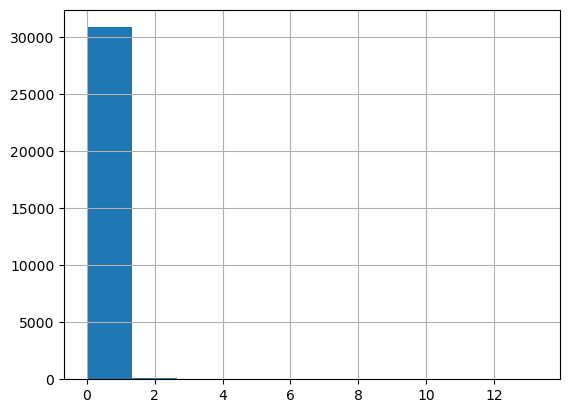

In [36]:
df_new['indive_mape'].hist()

In [56]:

y_all=y_all=pd.concat([df_train, df_test])[response_col].values
all_idx=np.arange(0, len(y_all))
pred_dic= dict(zip(all_idx, response_transformer.inverse_transform(y_pred.cpu().detach().numpy()).flatten()))
true_dic=dict(zip(all_idx, y_all))
distance=data.edge_attr.cpu()
edge_index_att= torch.cat([data.edge_index.cpu(), torch.t(atts.cpu())], dim=0)
edge_index_att= torch.cat([edge_index_att, torch.t(distance)], dim=0)
print(edge_index_att.shape)
test_edge_index=edge_index_att[:,edge_index_att[1]>train_idx[-1]]

df_con=df_con= pd.DataFrame({'source':test_edge_index[0].detach().numpy(),
                      'target':test_edge_index[1].detach().numpy(),
                            'att': test_edge_index[2].detach().numpy(),
                           'distance':test_edge_index[3].detach().numpy() })
df_con['source_pred']=df_con['source'].map(pred_dic)
df_con['target_pred']=df_con['target'].map(pred_dic)
df_con['pred_diff']=abs(df_con['target_pred']-df_con['source_pred'])
df_con['target_true']=df_con['target'].map(true_dic)
df_con['source_true']=df_con['source'].map(true_dic)





torch.Size([24, 5802868])


In [ ]:
df_con.groupby('target').size()

In [57]:
def get_top_n(df_con,n=5, sort_method= 'pred_diff',aggr='mean', source_metric='pred',hard_n_cut_off=False):
    '''
    this function gets the comps and evaluate its performance.
    args: 
    df_con: dataframe containing the source target ids, predictions, true values, and attention values 
    n: number of comps
    sort_method: ranking mechanism where pred_diff sorts by abs prediction differences between the neighbors and the target, and attention ranks solely based on attention
    aggr: aggregation method of the top n comps : mean, median, att_weighted
    source_metric: true means calculated metric with y_true of comps, pred means calculate metric based on y_pred of comps
    hard_n_cutt_off: remove 
    '''
    if sort_method == 'pred_diff':
        df_con=df_con.sort_values(['target', 'pred_diff'])
        top_n_df=df_con.groupby('target').head(n)
        
    if sort_method=='attention':
        df_con=df_con.sort_values(['target', 'att'])
        top_n_df=df_con.groupby('target').head(n)
    if hard_n_cut_off==True: #this removes the nodes that have less than n source neighbors
        n_count=dict(zip(df_con.groupby('target').size().reset_index()['target'].values,
                df_con.groupby('target').size().reset_index()[0].values))
        
        top_n_df['n_count']=top_n_df['target'].map(n_count)
        # print(len)
        top_n_df=top_n_df.loc[top_n_df['n_count']>=n]
        # print(len(top_n_df))
    mean_distance=top_n_df['distance'].mean()
    median_distance=top_n_df['distance'].median()
    print(f'neighbor distance average in km: {mean_distance}')
    print(f'neighbor distance median in km: {median_distance}')
    if aggr=='mean':
        agg_df=top_n_df[['target', 'source_pred','source_true', 'target_pred', 'target_true']].groupby('target').mean()
    
    if aggr=='median':
        agg_df=top_n_df[['target', 'source_pred','source_true', 'target_pred', 'target_true']].groupby('target').median()
    # out= pd.DataFrame([evaluate_preds(agg_df['target_true'].values, *y_pred_1)], index=["comps"])
    
    if aggr=='att_weighted':
        # group=top_n_df.groupby('target').sum()
        # print(group.loc[group['att']==0])
        if source_metric=='pred':
            top_n_df['att']=top_n_df['att']+0.000001
            agg_df=top_n_df[['target', 'source_pred', 'target_pred', 'target_true','att']].groupby(['target']).apply(
                lambda x: pd.Series([
                    np.mean(x['target_true']),
                    np.average(x['source_pred'], weights=x['att'])
                ], index=['target_true', 'source_pred'])
            )
        if source_metric=='true':
            top_n_df['att']=top_n_df['att']+0.000001
            agg_df=top_n_df[['target', 'source_pred','source_true', 'target_pred', 'target_true','att']].groupby(['target']).apply(
                lambda x: pd.Series([
                    np.mean(x['target_true']),
                    np.average(x['source_true'], weights=x['att'])
                ], index=['target_true', 'source_true'])
            )
    if source_metric=='pred':
        out= pd.DataFrame([evaluate_preds(agg_df['target_true'].values,agg_df['source_pred'].values)], index=["comps"])


    if source_metric=='true':
        out= pd.DataFrame([evaluate_preds(agg_df['target_true'].values,agg_df['source_true'].values)], index=["comps"])
    
    return out

In [58]:
get_top_n(df_con,n=5, sort_method='attention', aggr='att_weighted', source_metric='true', hard_n_cut_off=True)

/tmp/ipykernel_149/2641838427.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_df['n_count']=top_n_df['target'].map(n_count)


neighbor distance average in km: 0.5718359351158142
neighbor distance median in km: 0.5947365760803223


,Count,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
comps,30492,-1.119966,800662.409521,583454.403253,0.878116,0.540088,1.0317,0.600684


In [59]:
get_top_n(df_con,n=5, sort_method='pred_diff', aggr='att_weighted', source_metric='true', hard_n_cut_off=True)

/tmp/ipykernel_149/2641838427.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_df['n_count']=top_n_df['target'].map(n_count)


neighbor distance average in km: 0.5974395275115967
neighbor distance median in km: 0.62982177734375


,Count,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
comps,30492,0.45722,225906.691218,99899.051341,-0.031963,-0.051058,0.178107,0.125998


In [60]:
get_top_n(df_con,n=5, sort_method='pred_diff', aggr='mean', source_metric='true', hard_n_cut_off=True)

neighbor distance average in km: 0.5974395275115967
neighbor distance median in km: 0.62982177734375


/tmp/ipykernel_149/2641838427.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_df['n_count']=top_n_df['target'].map(n_count)


,Count,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
comps,30492,0.51543,205247.871986,93990.0,-0.01798,-0.041948,0.16605,0.116294


In [61]:
get_top_n(df_con,n=5, sort_method='pred_diff', aggr='median', source_metric='true', hard_n_cut_off=True)

neighbor distance average in km: 0.5974395275115967
neighbor distance median in km: 0.62982177734375


/tmp/ipykernel_149/2641838427.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_df['n_count']=top_n_df['target'].map(n_count)


,Count,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
comps,30492,0.480909,213168.149023,95000.0,-0.028896,-0.049434,0.168431,0.119048


In [ ]:
import matplotlib.pyplot as plt
df_con['target'].value_counts()
_ = plt.hist(df_con['target'].value_counts().values, bins='auto')  # arguments are passed to np.histogram
plt.title(f'{version} link histogram on the test sampel')
# Text(0.5, 1.0, "Connection (to target) Histogram with 'auto' bins")
plt.show()